## 1. Setup and Imports

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Time series libraries
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

# Create output directory
import os
os.makedirs('../results', exist_ok=True)
os.makedirs('../models', exist_ok=True)
print("\n✓ Output directories ready")

✓ All libraries imported successfully!
NumPy version: 2.3.4
Pandas version: 2.3.3

✓ Output directories ready


## 2. Load and Prepare Time Series Data

We'll work with the provided time series data:

**Y = [50, 54, 56, 53, 52, 55, 57]**

In [3]:
# Define the time series data
Y = [50, 54, 56, 53, 52, 55, 57]

# Convert to pandas Series with time index
time_index = pd.date_range(start='2024-01-01', periods=len(Y), freq='D')
ts_data = pd.Series(Y, index=time_index, name='Value')

print("Time Series Data:")
print("="*50)
print(ts_data)
print("\nData Summary:")
print(f"  Length: {len(ts_data)}")
print(f"  Mean: {ts_data.mean():.4f}")
print(f"  Std Dev: {ts_data.std():.4f}")
print(f"  Min: {ts_data.min():.4f}")
print(f"  Max: {ts_data.max():.4f}")
print(f"  Range: {ts_data.max() - ts_data.min():.4f}")

Time Series Data:
2024-01-01    50
2024-01-02    54
2024-01-03    56
2024-01-04    53
2024-01-05    52
2024-01-06    55
2024-01-07    57
Freq: D, Name: Value, dtype: int64

Data Summary:
  Length: 7
  Mean: 53.8571
  Std Dev: 2.4103
  Min: 50.0000
  Max: 57.0000
  Range: 7.0000


## 3. Visualize the Time Series

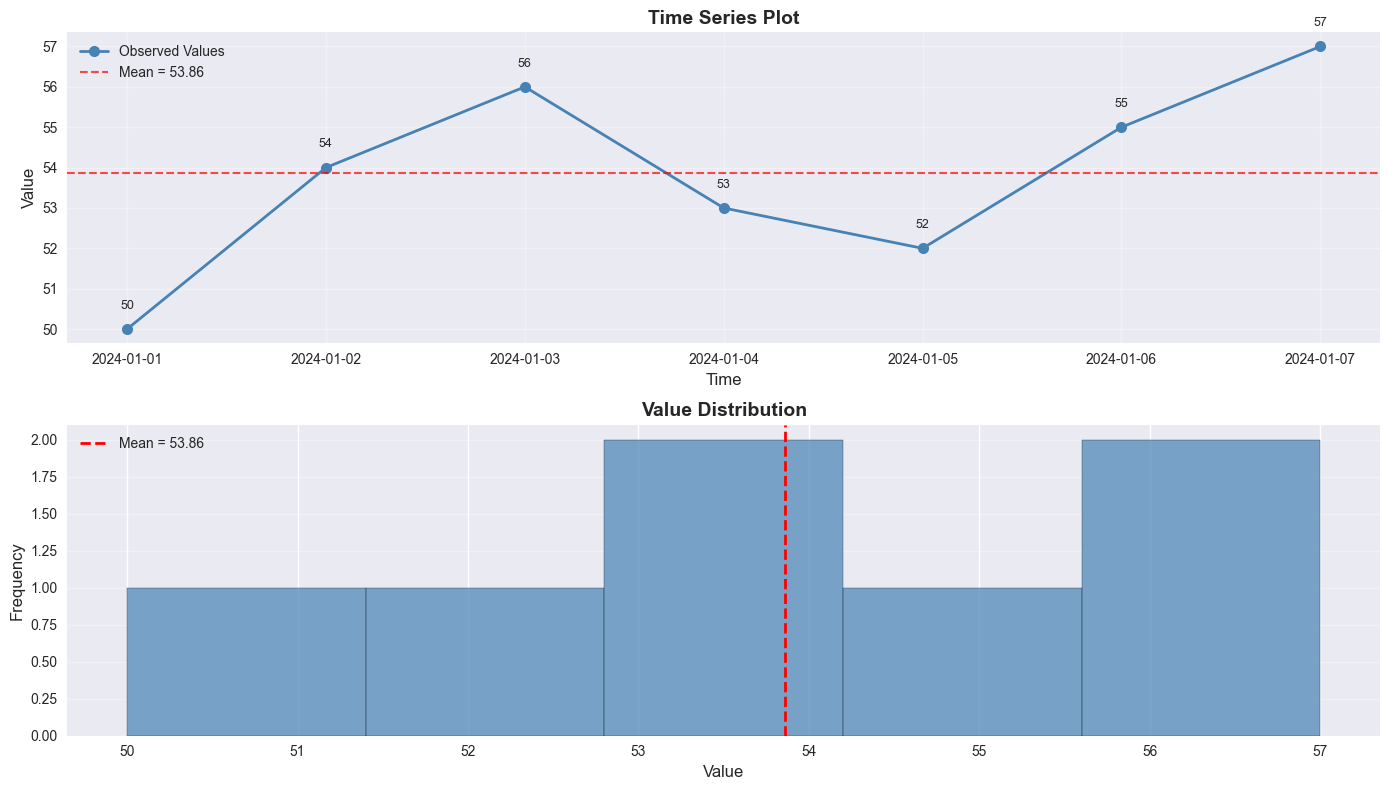

✓ Time series visualization saved


In [4]:
# Plot the time series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original time series
axes[0].plot(ts_data.index, ts_data.values, marker='o', linestyle='-', 
             linewidth=2, markersize=8, color='steelblue', label='Observed Values')
axes[0].axhline(y=ts_data.mean(), color='red', linestyle='--', 
                linewidth=1.5, alpha=0.7, label=f'Mean = {ts_data.mean():.2f}')
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('Time Series Plot', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Add value labels
for i, (date, value) in enumerate(zip(ts_data.index, ts_data.values)):
    axes[0].text(date, value + 0.5, str(value), ha='center', fontsize=9)

# Distribution histogram
axes[1].hist(ts_data.values, bins=5, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=ts_data.mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean = {ts_data.mean():.2f}')
axes[1].set_xlabel('Value', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Value Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/time_series_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Time series visualization saved")

## 4. Exploratory Data Analysis

### 4.1 First Differences
Calculate the first differences to see the change from one period to the next.

First Differences (Y_t - Y_{t-1}):
2024-01-02    4.0
2024-01-03    2.0
2024-01-04   -3.0
2024-01-05   -1.0
2024-01-06    3.0
2024-01-07    2.0
Freq: D, Name: Value, dtype: float64

Mean of differences: 1.1667
Std of differences: 2.6394


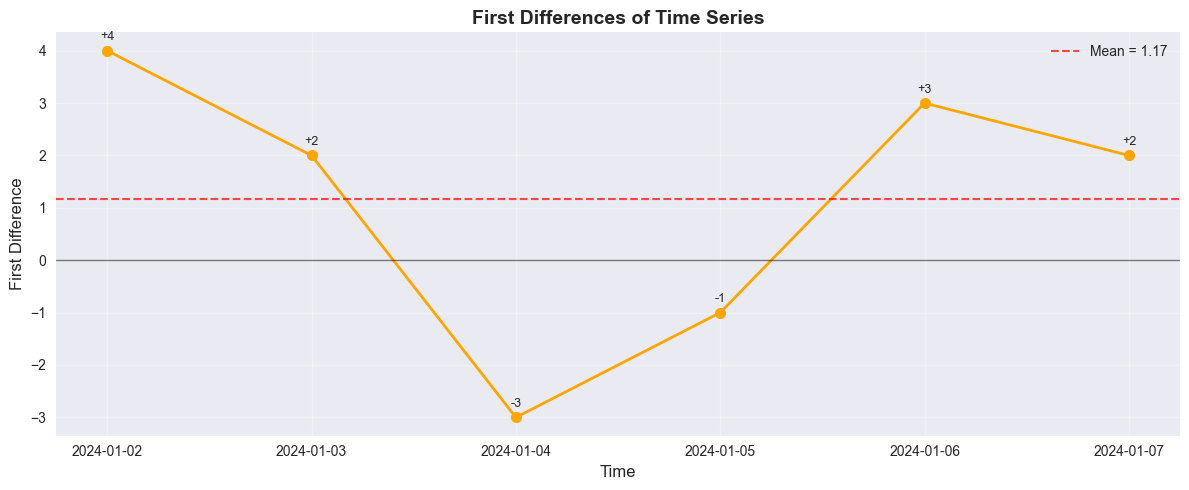

In [5]:
# Calculate first differences
differences = ts_data.diff().dropna()

print("First Differences (Y_t - Y_{t-1}):")
print("="*50)
print(differences)
print(f"\nMean of differences: {differences.mean():.4f}")
print(f"Std of differences: {differences.std():.4f}")

# Plot first differences
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(differences.index, differences.values, marker='o', linestyle='-', 
        linewidth=2, markersize=8, color='orange')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.axhline(y=differences.mean(), color='red', linestyle='--', 
           linewidth=1.5, alpha=0.7, label=f'Mean = {differences.mean():.2f}')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('First Difference', fontsize=12)
ax.set_title('First Differences of Time Series', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Add value labels
for i, (date, value) in enumerate(zip(differences.index, differences.values)):
    ax.text(date, value + 0.2, f'{value:+.0f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../results/first_differences.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.2 Lag Plot
Visualize the relationship between Y_t and Y_{t-1}

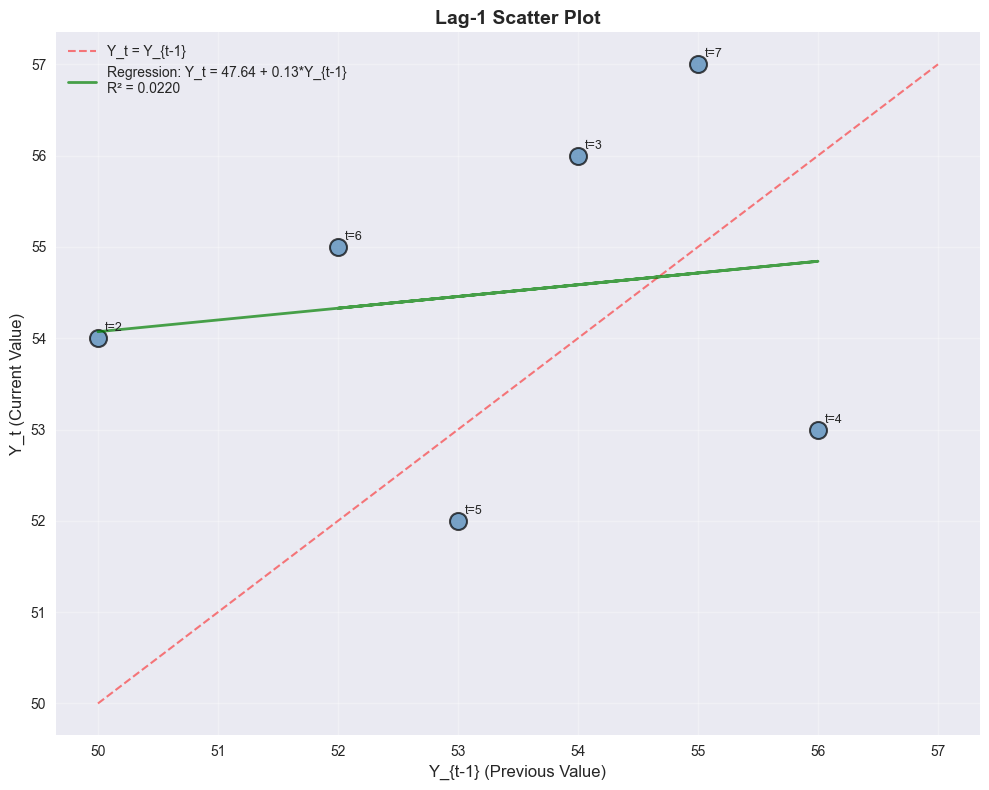


Lag-1 Correlation Analysis:
Slope (φ₁ estimate): 0.1286
Intercept (φ₀ estimate): 47.6429
R-squared: 0.0220
Correlation coefficient: 0.1485
P-value: 0.7789


In [6]:
# Create lag plot
y_t = ts_data.values[1:]  # Current values
y_t_minus_1 = ts_data.values[:-1]  # Lagged values

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(y_t_minus_1, y_t, s=150, alpha=0.7, color='steelblue', edgecolors='black', linewidth=1.5)

# Add labels to points
for i, (x, y) in enumerate(zip(y_t_minus_1, y_t)):
    ax.annotate(f't={i+2}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add reference line y = x
min_val = min(min(y_t), min(y_t_minus_1))
max_val = max(max(y_t), max(y_t_minus_1))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, linewidth=1.5, label='Y_t = Y_{t-1}')

# Calculate and plot regression line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(y_t_minus_1, y_t)
line = slope * np.array(y_t_minus_1) + intercept
ax.plot(y_t_minus_1, line, 'g-', linewidth=2, alpha=0.7, 
        label=f'Regression: Y_t = {intercept:.2f} + {slope:.2f}*Y_{{t-1}}\nR² = {r_value**2:.4f}')

ax.set_xlabel('Y_{t-1} (Previous Value)', fontsize=12)
ax.set_ylabel('Y_t (Current Value)', fontsize=12)
ax.set_title('Lag-1 Scatter Plot', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/lag_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nLag-1 Correlation Analysis:")
print("="*50)
print(f"Slope (φ₁ estimate): {slope:.4f}")
print(f"Intercept (φ₀ estimate): {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"Correlation coefficient: {r_value:.4f}")
print(f"P-value: {p_value:.4f}")

## 5. Autocorrelation Analysis

### 5.1 ACF and PACF Plots

Autocorrelation Function (ACF):
Lag 0: 1.0000
Lag 1: 0.0281
Lag 2: -0.5504
Lag 3: 0.0802

Partial Autocorrelation Function (PACF):
Lag 0: 1.0000
Lag 1: 0.0281
Lag 2: -0.5516
Lag 3: 0.1722


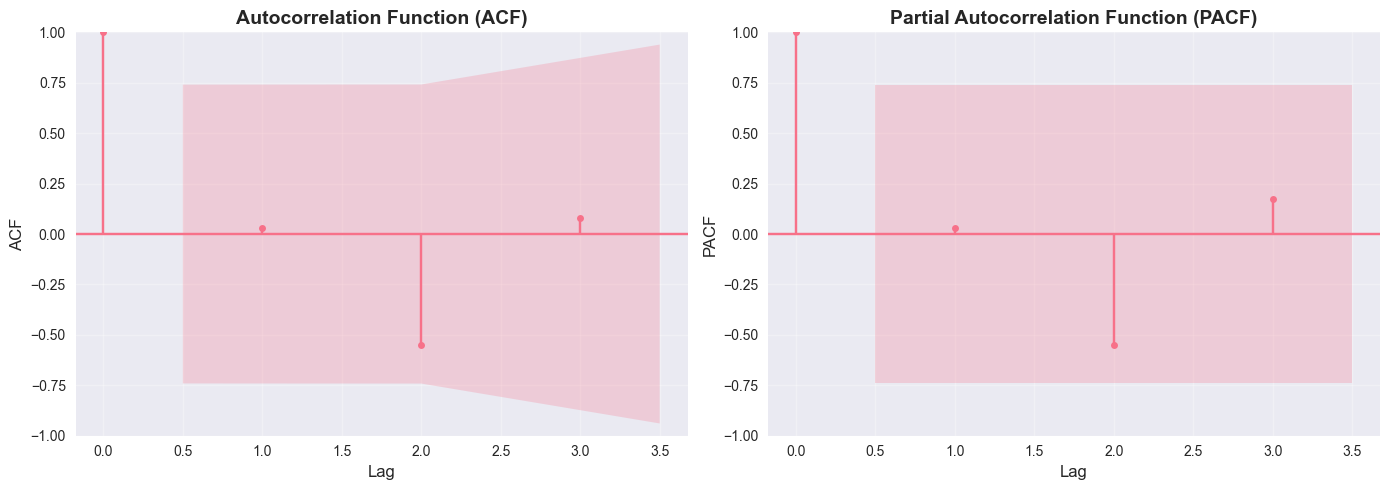


📊 Interpretation:
  • PACF at lag 1 = 0.0281 suggests AR(1) coefficient
  • ACF shows positive autocorrelation at lag 1


In [7]:
# Calculate ACF and PACF
acf_values = acf(ts_data, nlags=3)
pacf_values = pacf(ts_data, nlags=3, method='ywm')

print("Autocorrelation Function (ACF):")
print("="*50)
for i, val in enumerate(acf_values):
    print(f"Lag {i}: {val:.4f}")

print("\nPartial Autocorrelation Function (PACF):")
print("="*50)
for i, val in enumerate(pacf_values):
    print(f"Lag {i}: {val:.4f}")

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(ts_data, lags=3, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('ACF', fontsize=12)
axes[0].grid(True, alpha=0.3)

# PACF plot
plot_pacf(ts_data, lags=3, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('PACF', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/acf_pacf_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Interpretation:")
print(f"  • PACF at lag 1 = {pacf_values[1]:.4f} suggests AR(1) coefficient")
print(f"  • ACF shows {'positive' if acf_values[1] > 0 else 'negative'} autocorrelation at lag 1")

## 6. Fit AR(1) Model

### 6.1 Using statsmodels AutoReg

In [8]:
# Fit AR(1) model
print("="*70)
print("FITTING AR(1) MODEL")
print("="*70)

# Method 1: Using AutoReg
model_ar = AutoReg(ts_data, lags=1, trend='c')  # 'c' includes constant term
results_ar = model_ar.fit()

print("\n" + results_ar.summary().as_text())

# Extract parameters
phi_0 = results_ar.params['const']  # Constant term
phi_1 = results_ar.params['Value.L1']  # AR(1) coefficient

print("\n" + "="*70)
print("AR(1) MODEL PARAMETERS")
print("="*70)
print(f"\nModel Equation: Y_t = {phi_0:.4f} + {phi_1:.4f} * Y_{{t-1}} + ε_t")
print(f"\nParameter Estimates:")
print(f"  φ₀ (Constant): {phi_0:.4f}")
print(f"  φ₁ (AR coefficient): {phi_1:.4f}")
print(f"  σ² (Residual variance): {results_ar.sigma2:.4f}")

# Stationarity check
print(f"\n📊 Stationarity Check:")
if abs(phi_1) < 1:
    print(f"  ✓ Process is STATIONARY (|φ₁| = {abs(phi_1):.4f} < 1)")
else:
    print(f"  ✗ Process is NON-STATIONARY (|φ₁| = {abs(phi_1):.4f} ≥ 1)")

# Interpretation
print(f"\n💡 Interpretation:")
if phi_1 > 0:
    print(f"  • Positive AR coefficient ({phi_1:.4f}) indicates positive persistence")
    print(f"  • Values tend to remain at similar levels over time")
elif phi_1 < 0:
    print(f"  • Negative AR coefficient ({phi_1:.4f}) indicates oscillating behavior")
    print(f"  • High values tend to be followed by low values and vice versa")
else:
    print(f"  • AR coefficient near zero suggests little to no autocorrelation")

FITTING AR(1) MODEL

                            AutoReg Model Results                             
Dep. Variable:                  Value   No. Observations:                    7
Model:                     AutoReg(1)   Log Likelihood                 -11.658
Method:               Conditional MLE   S.D. of innovations              1.689
Date:                Fri, 14 Nov 2025   AIC                             29.316
Time:                        11:42:24   BIC                             28.691
Sample:                    01-02-2024   HQIC                            26.815
                         - 01-07-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.6429     18.660      2.553      0.011      11.070      84.216
Value.L1       0.1286      0.350      0.368      0.713      -0.557       0.814
                               

## 7. Model Diagnostics

### 7.1 Residual Analysis

Residuals:
2024-01-02   -0.071429
2024-01-03    1.414286
2024-01-04   -1.842857
2024-01-05   -2.457143
2024-01-06    0.671429
2024-01-07    2.285714
Freq: D, dtype: float64

Residual Statistics:
  Mean: -0.0000 (should be ≈ 0)
  Std Dev: 1.8501
  Min: -2.4571
  Max: 2.2857


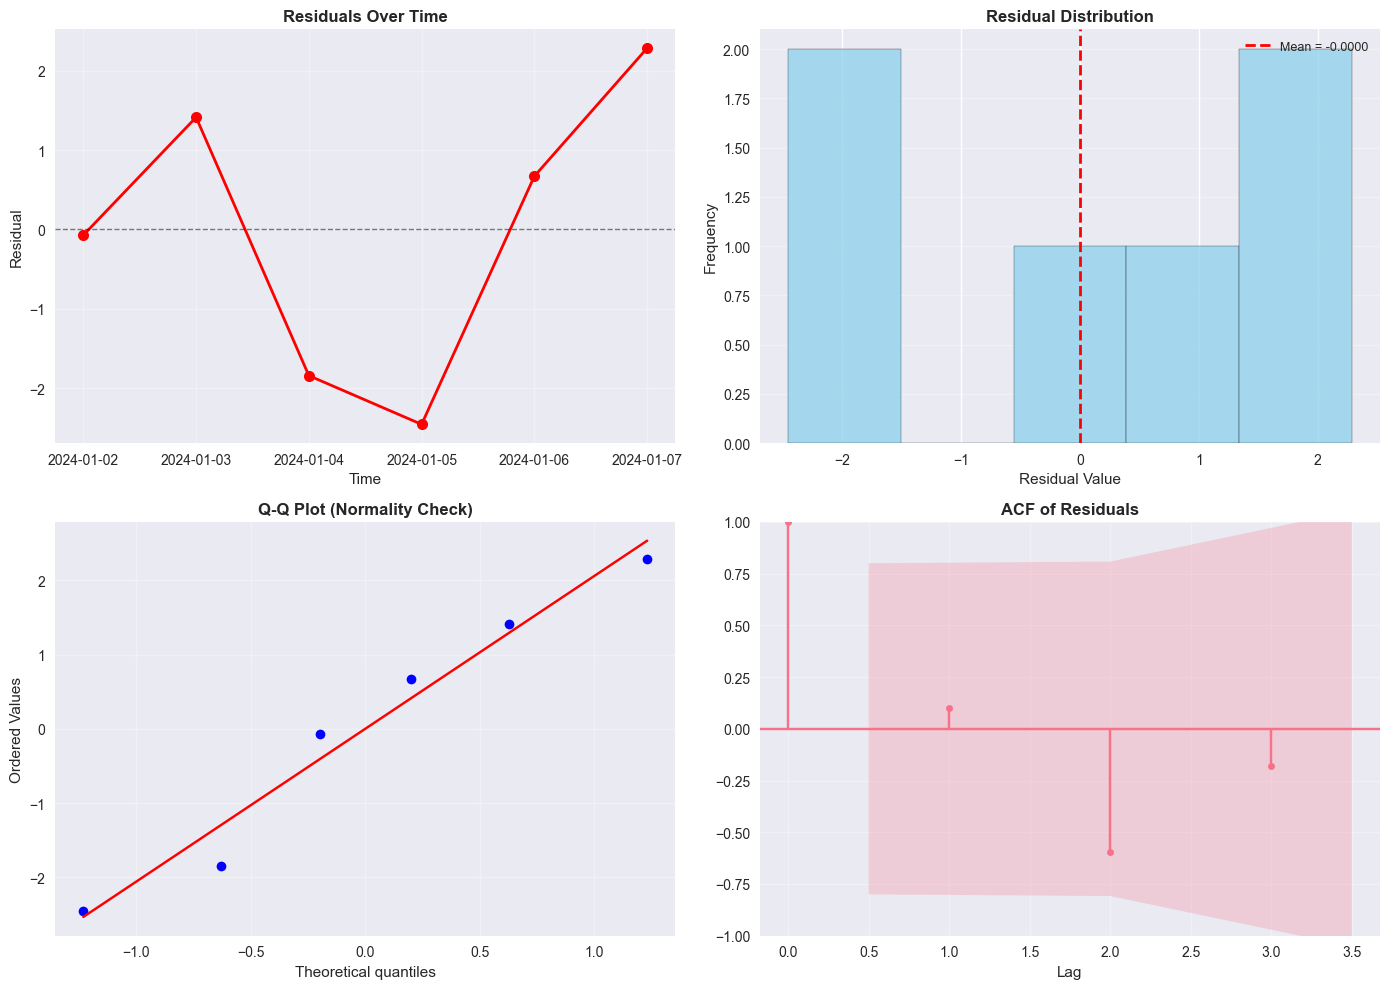


✓ Residual diagnostic plots saved


In [9]:
# Get residuals
residuals = results_ar.resid

print("Residuals:")
print("="*50)
print(residuals)

print("\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.4f} (should be ≈ 0)")
print(f"  Std Dev: {residuals.std():.4f}")
print(f"  Min: {residuals.min():.4f}")
print(f"  Max: {residuals.max():.4f}")

# Comprehensive residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals over time
axes[0, 0].plot(residuals.index, residuals.values, marker='o', linestyle='-', 
                linewidth=2, markersize=8, color='red')
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].set_xlabel('Time', fontsize=11)
axes[0, 0].set_ylabel('Residual', fontsize=11)
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=5, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=residuals.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean = {residuals.mean():.4f}')
axes[0, 1].set_xlabel('Residual Value', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF of residuals
plot_acf(residuals, lags=min(3, len(residuals)-1), ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('ACF of Residuals', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Lag', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/residual_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Residual diagnostic plots saved")

### 7.2 Statistical Tests

In [10]:
print("="*70)
print("STATISTICAL TESTS FOR MODEL DIAGNOSTICS")
print("="*70)

# 1. Ljung-Box Test for residual autocorrelation
print("\n1. Ljung-Box Test (Residual Autocorrelation):")
print("-" * 50)
try:
    lb_test = acorr_ljungbox(residuals, lags=[1], return_df=True)
    print(lb_test)
    lb_pvalue = lb_test['lb_pvalue'].values[0]
    if lb_pvalue > 0.05:
        print(f"  ✓ No significant autocorrelation in residuals (p = {lb_pvalue:.4f})")
    else:
        print(f"  ⚠ Significant autocorrelation detected (p = {lb_pvalue:.4f})")
except:
    print("  Note: Test requires more observations for reliable results")

# 2. Shapiro-Wilk Test for normality
print("\n2. Shapiro-Wilk Test (Normality of Residuals):")
print("-" * 50)
if len(residuals) >= 3:
    statistic, p_value = stats.shapiro(residuals)
    print(f"  Statistic: {statistic:.4f}")
    print(f"  P-value: {p_value:.4f}")
    if p_value > 0.05:
        print(f"  ✓ Residuals appear normally distributed (p = {p_value:.4f})")
    else:
        print(f"  ⚠ Residuals may not be normally distributed (p = {p_value:.4f})")
else:
    print("  Note: Insufficient observations for Shapiro-Wilk test")

# 3. Durbin-Watson statistic
print("\n3. Durbin-Watson Statistic (Autocorrelation):")
print("-" * 50)
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"  DW Statistic: {dw_stat:.4f}")
print(f"  Interpretation:")
if 1.5 < dw_stat < 2.5:
    print("    ✓ No significant autocorrelation (DW ≈ 2)")
elif dw_stat < 1.5:
    print("    ⚠ Positive autocorrelation may be present")
else:
    print("    ⚠ Negative autocorrelation may be present")

STATISTICAL TESTS FOR MODEL DIAGNOSTICS

1. Ljung-Box Test (Residual Autocorrelation):
--------------------------------------------------
   lb_stat  lb_pvalue
1  0.09536   0.757471
  ✓ No significant autocorrelation in residuals (p = 0.7575)

2. Shapiro-Wilk Test (Normality of Residuals):
--------------------------------------------------
  Statistic: 0.9487
  P-value: 0.7296
  ✓ Residuals appear normally distributed (p = 0.7296)

3. Durbin-Watson Statistic (Autocorrelation):
--------------------------------------------------
  DW Statistic: 1.4951
  Interpretation:
    ⚠ Positive autocorrelation may be present


## 8. Model Performance Metrics

MODEL PERFORMANCE METRICS

In-Sample Performance:
  Mean Squared Error (MSE): 2.8524
  Root Mean Squared Error (RMSE): 1.6889
  Mean Absolute Error (MAE): 1.4571
  Mean Absolute Percentage Error (MAPE): 2.68%
  R-squared: 0.0220

Model Information Criteria:
  AIC: 29.3162
  BIC: 28.6915
  Log-Likelihood: -11.6581


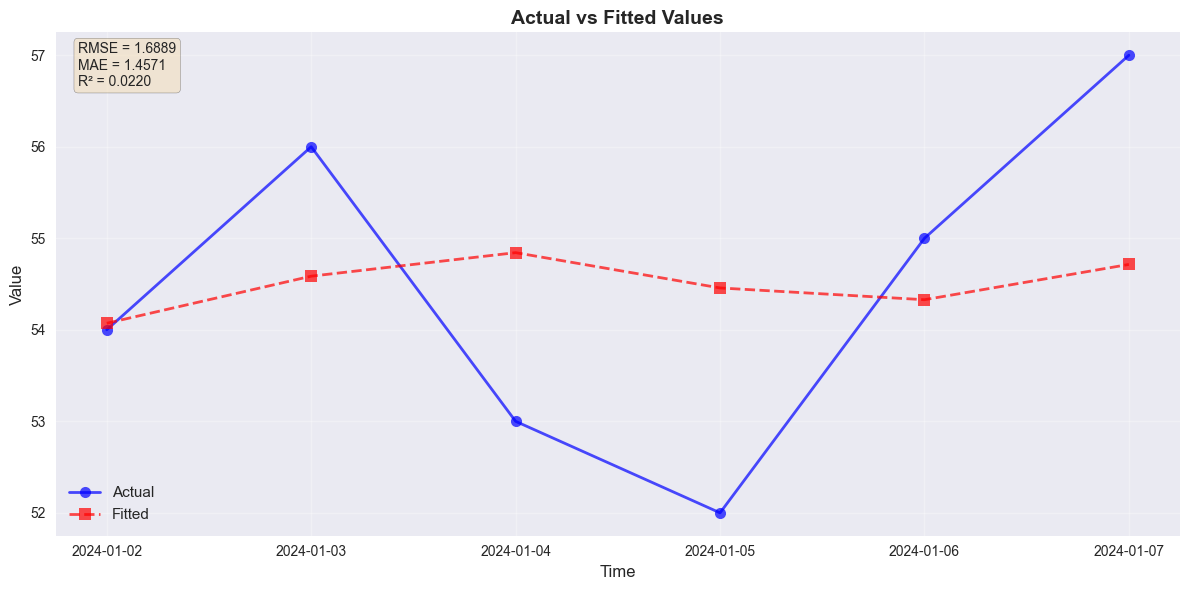

In [11]:
# Get fitted values
fitted_values = results_ar.fittedvalues

# Calculate metrics (note: fitted values start from t=2 for AR(1))
actual = ts_data[1:]  # Exclude first value
predicted = fitted_values

# Calculate performance metrics
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
r2 = r2_score(actual, predicted)

print("="*70)
print("MODEL PERFORMANCE METRICS")
print("="*70)
print(f"\nIn-Sample Performance:")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"  R-squared: {r2:.4f}")
print(f"\nModel Information Criteria:")
print(f"  AIC: {results_ar.aic:.4f}")
print(f"  BIC: {results_ar.bic:.4f}")
print(f"  Log-Likelihood: {results_ar.llf:.4f}")

# Plot actual vs fitted
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(actual.index, actual.values, marker='o', linestyle='-', 
        linewidth=2, markersize=8, color='blue', label='Actual', alpha=0.7)
ax.plot(predicted.index, predicted.values, marker='s', linestyle='--', 
        linewidth=2, markersize=8, color='red', label='Fitted', alpha=0.7)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Actual vs Fitted Values', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add performance metrics text box
textstr = f'RMSE = {rmse:.4f}\nMAE = {mae:.4f}\nR² = {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('../results/actual_vs_fitted.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Forecasting with AR(1) Model

### 9.1 Generate Forecasts

In [12]:
# Generate forecasts for next 3 periods
n_forecast = 3
forecast_results = results_ar.predict(start=len(ts_data), end=len(ts_data) + n_forecast - 1)

print("="*70)
print("FORECASTING")
print("="*70)
print(f"\nForecasting {n_forecast} periods ahead...\n")

# Create forecast dataframe
forecast_index = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), 
                               periods=n_forecast, freq='D')
forecast_df = pd.DataFrame({
    'Forecast': forecast_results.values
}, index=forecast_index)

print("Forecasted Values:")
print("-" * 50)
for date, value in zip(forecast_df.index, forecast_df['Forecast']):
    print(f"  {date.strftime('%Y-%m-%d')}: {value:.4f}")

# Manual calculation explanation
print("\n📐 Manual Forecast Calculation:")
print("-" * 50)
last_value = ts_data.iloc[-1]
forecast_1 = phi_0 + phi_1 * last_value
print(f"  t+1: {phi_0:.4f} + {phi_1:.4f} × {last_value} = {forecast_1:.4f}")

forecast_2 = phi_0 + phi_1 * forecast_1
print(f"  t+2: {phi_0:.4f} + {phi_1:.4f} × {forecast_1:.4f} = {forecast_2:.4f}")

forecast_3 = phi_0 + phi_1 * forecast_2
print(f"  t+3: {phi_0:.4f} + {phi_1:.4f} × {forecast_2:.4f} = {forecast_3:.4f}")

FORECASTING

Forecasting 3 periods ahead...

Forecasted Values:
--------------------------------------------------
  2024-01-08: 54.9714
  2024-01-09: 54.7106
  2024-01-10: 54.6771

📐 Manual Forecast Calculation:
--------------------------------------------------
  t+1: 47.6429 + 0.1286 × 57 = 54.9714
  t+2: 47.6429 + 0.1286 × 54.9714 = 54.7106
  t+3: 47.6429 + 0.1286 × 54.7106 = 54.6771


### 9.2 Visualize Forecasts

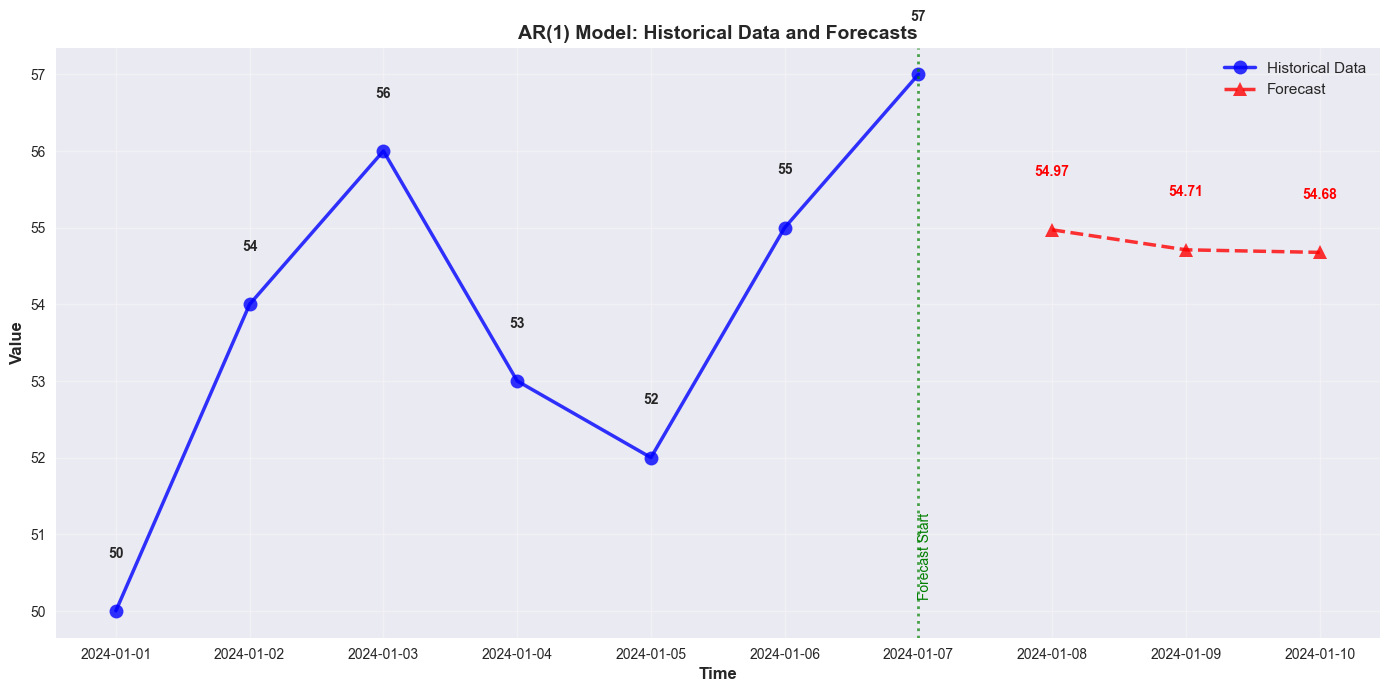


✓ Forecast visualization saved


In [13]:
# Create comprehensive forecast plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot historical data
ax.plot(ts_data.index, ts_data.values, marker='o', linestyle='-', 
        linewidth=2.5, markersize=10, color='blue', label='Historical Data', alpha=0.8)

# Plot forecasts
ax.plot(forecast_df.index, forecast_df['Forecast'], marker='^', linestyle='--', 
        linewidth=2.5, markersize=10, color='red', label='Forecast', alpha=0.8)

# Add value labels
for i, (date, value) in enumerate(zip(ts_data.index, ts_data.values)):
    ax.text(date, value + 0.7, str(value), ha='center', fontsize=10, fontweight='bold')

for i, (date, value) in enumerate(zip(forecast_df.index, forecast_df['Forecast'])):
    ax.text(date, value + 0.7, f'{value:.2f}', ha='center', fontsize=10, 
            fontweight='bold', color='red')

# Add vertical line separating historical and forecast
ax.axvline(x=ts_data.index[-1], color='green', linestyle=':', linewidth=2, alpha=0.7)
ax.text(ts_data.index[-1], ax.get_ylim()[0] + 0.5, 'Forecast Start', 
        rotation=90, verticalalignment='bottom', fontsize=10, color='green')

ax.set_xlabel('Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Value', fontsize=12, fontweight='bold')
ax.set_title('AR(1) Model: Historical Data and Forecasts', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/forecast_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Forecast visualization saved")

## 10. Summary and Conclusions

In [14]:
print("="*70)
print("AR(1) MODEL ANALYSIS SUMMARY")
print("="*70)

print("\n📊 DATA SUMMARY:")
print("-" * 50)
print(f"  Original Data: {list(ts_data.values)}")
print(f"  Number of observations: {len(ts_data)}")
print(f"  Mean: {ts_data.mean():.4f}")
print(f"  Standard deviation: {ts_data.std():.4f}")

print("\n📈 MODEL SPECIFICATION:")
print("-" * 50)
print(f"  Model: AR(1) with constant")
print(f"  Equation: Y_t = {phi_0:.4f} + {phi_1:.4f} * Y_{{t-1}} + ε_t")

print("\n🎯 PARAMETER ESTIMATES:")
print("-" * 50)
print(f"  φ₀ (Constant): {phi_0:.4f}")
print(f"  φ₁ (AR coefficient): {phi_1:.4f}")
print(f"  Residual variance (σ²): {results_ar.sigma2:.4f}")

print("\n✅ MODEL DIAGNOSTICS:")
print("-" * 50)
print(f"  Stationarity: {'Yes' if abs(phi_1) < 1 else 'No'} (|φ₁| = {abs(phi_1):.4f})")
print(f"  Residual mean: {residuals.mean():.4f} (should be ≈ 0)")
print(f"  Durbin-Watson: {dw_stat:.4f}")

print("\n📊 MODEL PERFORMANCE:")
print("-" * 50)
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  R²: {r2:.4f}")
print(f"  AIC: {results_ar.aic:.4f}")
print(f"  BIC: {results_ar.bic:.4f}")

print("\n🔮 FORECASTS:")
print("-" * 50)
for i, (date, value) in enumerate(zip(forecast_df.index, forecast_df['Forecast']), 1):
    print(f"  Period t+{i} ({date.strftime('%Y-%m-%d')}): {value:.4f}")

print("\n💡 KEY INSIGHTS:")
print("-" * 50)
if phi_1 > 0.5:
    print("  • Strong positive persistence in the series")
    print("  • Values tend to remain at similar levels")
elif phi_1 > 0:
    print("  • Moderate positive persistence in the series")
    print("  • Some tendency for values to persist")
elif phi_1 < -0.5:
    print("  • Strong negative persistence (oscillation)")
    print("  • Values tend to alternate between high and low")
elif phi_1 < 0:
    print("  • Moderate negative persistence")
    print("  • Some oscillating behavior")
else:
    print("  • Little to no autocorrelation")
    print("  • Series behaves like white noise")

print("\n📁 OUTPUT FILES:")
print("-" * 50)
print("  • time_series_visualization.png")
print("  • first_differences.png")
print("  • lag_plot.png")
print("  • acf_pacf_plots.png")
print("  • residual_diagnostics.png")
print("  • actual_vs_fitted.png")
print("  • forecast_plot.png")

print("\n" + "="*70)
print("✅ AR(1) MODEL ANALYSIS COMPLETE!")
print("="*70)

AR(1) MODEL ANALYSIS SUMMARY

📊 DATA SUMMARY:
--------------------------------------------------
  Original Data: [np.int64(50), np.int64(54), np.int64(56), np.int64(53), np.int64(52), np.int64(55), np.int64(57)]
  Number of observations: 7
  Mean: 53.8571
  Standard deviation: 2.4103

📈 MODEL SPECIFICATION:
--------------------------------------------------
  Model: AR(1) with constant
  Equation: Y_t = 47.6429 + 0.1286 * Y_{t-1} + ε_t

🎯 PARAMETER ESTIMATES:
--------------------------------------------------
  φ₀ (Constant): 47.6429
  φ₁ (AR coefficient): 0.1286
  Residual variance (σ²): 2.8524

✅ MODEL DIAGNOSTICS:
--------------------------------------------------
  Stationarity: Yes (|φ₁| = 0.1286)
  Residual mean: -0.0000 (should be ≈ 0)
  Durbin-Watson: 1.4951

📊 MODEL PERFORMANCE:
--------------------------------------------------
  RMSE: 1.6889
  MAE: 1.4571
  MAPE: 2.68%
  R²: 0.0220
  AIC: 29.3162
  BIC: 28.6915

🔮 FORECASTS:
-------------------------------------------------

## 11. Save Model Results

In [ ]:
# Save model results to file
import pickle
from datetime import datetime

# Save model object
model_filename = f'../models/ar1_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(results_ar, f)

print(f"✓ Model saved to: {model_filename}")

# Save results summary to text file
summary_filename = '../results/ar1_model_summary.txt'
with open(summary_filename, 'w') as f:
    f.write("AR(1) MODEL ANALYSIS SUMMARY\n")
    f.write("=" * 70 + "\n\n")
    
    f.write("DATA:\n")
    f.write(f"Original series: {list(ts_data.values)}\n")
    f.write(f"Length: {len(ts_data)}\n\n")
    
    f.write("MODEL:\n")
    f.write(f"Equation: Y_t = {phi_0:.4f} + {phi_1:.4f} * Y_{{t-1}} + ε_t\n\n")
    
    f.write("PARAMETERS:\n")
    f.write(f"φ₀ (Constant): {phi_0:.4f}\n")
    f.write(f"φ₁ (AR coefficient): {phi_1:.4f}\n")
    f.write(f"σ² (Residual variance): {results_ar.sigma2:.4f}\n\n")
    
    f.write("PERFORMANCE:\n")
    f.write(f"RMSE: {rmse:.4f}\n")
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"R²: {r2:.4f}\n")
    f.write(f"AIC: {results_ar.aic:.4f}\n")
    f.write(f"BIC: {results_ar.bic:.4f}\n\n")
    
    f.write("FORECASTS:\n")
    for i, (date, value) in enumerate(zip(forecast_df.index, forecast_df['Forecast']), 1):
        f.write(f"t+{i} ({date.strftime('%Y-%m-%d')}): {value:.4f}\n")

print(f"✓ Summary saved to: {summary_filename}")

# Save forecast results
forecast_df.to_csv('../results/ar1_forecasts.csv')
print("✓ Forecasts saved to: ../results/ar1_forecasts.csv")

print("\n✅ All results saved successfully!")